In [1]:
import re
from collections import defaultdict
DATA=[
    "fisher_dev.en",
    "fisher_dev2.en",
    "fisher_test.en"
]
MODEL=[
    "arnomtl",
    "arbeam10",
    "st",
    "seg4",
    "seg6",
    "seg8",
    "seg10",
#     "arbeam1",
#     "arbeam5",
#     "arnoload",
]

srcs = defaultdict(list)
hypos = defaultdict(list)
refs = defaultdict(list)
scores = defaultdict(list)
hypo_scores = defaultdict(list)
# hypo_acc_scores = defaultdict(list)

metric="kendalltau"
for d in DATA:
    for m in MODEL:
        # read hypothesis reorder score hypo_scores
        with open(f"metric/{metric}/{d}.{m}", "r") as f:
            for line in f:
                hypo_scores[m].append(float(line.strip()))
                
#         # read hypothesis reorder correctness score as hypo_acc_scores 
#         allaccs = [[],[],[],[]]
#         with open(f"metric/{metric}/{d}.{m}..acc", "r") as f:
#             for line in f:
#                 allaccs[0].append(float(line.strip()))
#         for i in range(1, 4):
#             with open(f"metric/{metric}/{d}.{m}.{i}.acc", "r") as f:
#                 for line in f:
#                     allaccs[i].append(float(line.strip()))
#         hypo_acc_scores[m].extend(
#             list(zip(*allaccs)) # [(ref, ref1, ref2, ref3), ...]
#         )
        
        # read hypos
        with open(f"metric/dump/{d}.{m}.hyp", "r") as f:
            for line in f:
                hypos[m].append(line.strip())
               
    # read srcs
    with open(f"metric/dump/{d}.st.src", "r") as f:
        for line in f:
            srcs[MODEL[0]].append(line.strip())
            
    # read refs
    allrefs = [[],[],[],[]]
    with open(f"metric/dump/{d}.st.ref", "r") as f:
        for line in f:
            allrefs[0].append(line.strip())
    for i in range(1, 4):
        with open(f"metric/dump/{d}.st.ref{i}", "r") as f:
            for line in f:
                allrefs[i].append(line.strip())
    refs[MODEL[0]].extend(
        list(zip(*allrefs)) # [(ref, ref1, ref2, ref3), ...]
    )

    # read scores
    ref_sc = [[],[],[],[]]
    with open(f"metric/{metric}/{d}.ref", "r") as f:
        for line in f:
            ref_sc[0].append(float(line.strip()))
    for i in range(1, 4):
        with open(f"metric/{metric}/{d}.ref{i}", "r") as f:
            for line in f:
                ref_sc[i].append(float(line.strip()))
                
    scores[MODEL[0]].extend(
        [sum(x)/4 for x in zip(*ref_sc)]
    )
            
    for m in MODEL[1:]:
        srcs[m] = srcs[MODEL[0]]
        refs[m] = refs[MODEL[0]]
        scores[m] = scores[MODEL[0]]

In [2]:
print([len(h) for h in srcs.values()])
print([len(h) for h in hypos.values()])
print([len(h) for h in refs.values()])
print([len(h) for h in scores.values()])
print([len(h) for h in hypo_scores.values()])
# print([len(h) for h in hypo_acc_scores.values()])

[11568, 11568, 11568, 11568, 11568, 11568, 11568]
[11568, 11568, 11568, 11568, 11568, 11568, 11568]
[11568, 11568, 11568, 11568, 11568, 11568, 11568]
[11568, 11568, 11568, 11568, 11568, 11568, 11568]
[11568, 11568, 11568, 11568, 11568, 11568, 11568]


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
sns.set()

In [4]:
# clear bins
!rm metric/bins/*_bin_*

In [5]:
import sacrebleu
import numpy as np

nbins = 11
remove_0 = True
plots = defaultdict(list)
for i,m in enumerate(MODEL):    
    hypbin = [[] for u in range(nbins+1)]
    refbin = [[] for u in range(nbins+1)]
    ktdbin = [[] for u in range(nbins+1)]
    
    zerodata = []
    data = []    
    for d in zip(scores[m], hypos[m], refs[m]):
        if d[0] == 0:
            zerodata.append(d)
        else:
            data.append(d)
    
    data = sorted(data, key=lambda d: d[0])
    step = len(data)//nbins + 1
    
    for (sc, h, t) in zerodata:
        hypbin[0].append(h)
        refbin[0].append(t)
        ktdbin[0].append(sc)
    
    for u, (sc, h, t) in enumerate(data):        
        index = int(u // step) + 1
        hypbin[index].append(h)
        refbin[index].append(t)
        ktdbin[index].append(sc)
            
    x = []
    y = []
    for sc, h, t in zip(ktdbin, hypbin, refbin):
        noir = np.mean(sc)
        with open(f"metric/bins/{m}_bin_{noir:.05f}_.hyp", "w") as f1, \
        open(f"metric/bins/{m}_bin_{noir:.05f}_.ref", "w") as tf, \
        open(f"metric/bins/{m}_bin_{noir:.05f}_.ref1", "w") as tf1, \
        open(f"metric/bins/{m}_bin_{noir:.05f}_.ref2", "w") as tf2, \
        open(f"metric/bins/{m}_bin_{noir:.05f}_.ref3", "w") as tf3:
            for hsent in h:
                f1.write(hsent+"\n")
            for ref, ref1, ref2, ref3 in t:
                tf.write(ref+"\n")
                tf1.write(ref1+"\n")
                tf2.write(ref2+"\n")
                tf3.write(ref3+"\n")

In [6]:
# calculate multi-bleu
!cd metric/bins/ && bash get_multi_bleu_each_bins.sh

In [7]:
# read in multibleu results
plots = defaultdict(lambda: defaultdict(list))
with open("metric/bins/multi_bleu_results.txt", "r") as f:
    for line in f:
        m, bins, *bleu_res = line.strip().split()
        if remove_0 and float(bins) == 0:
            continue
        bleu = bleu_res[bleu_res.index('=')+1].strip(',')
        plots[m]['x'].append(float(bins))
        plots[m]['y'].append(float(bleu))

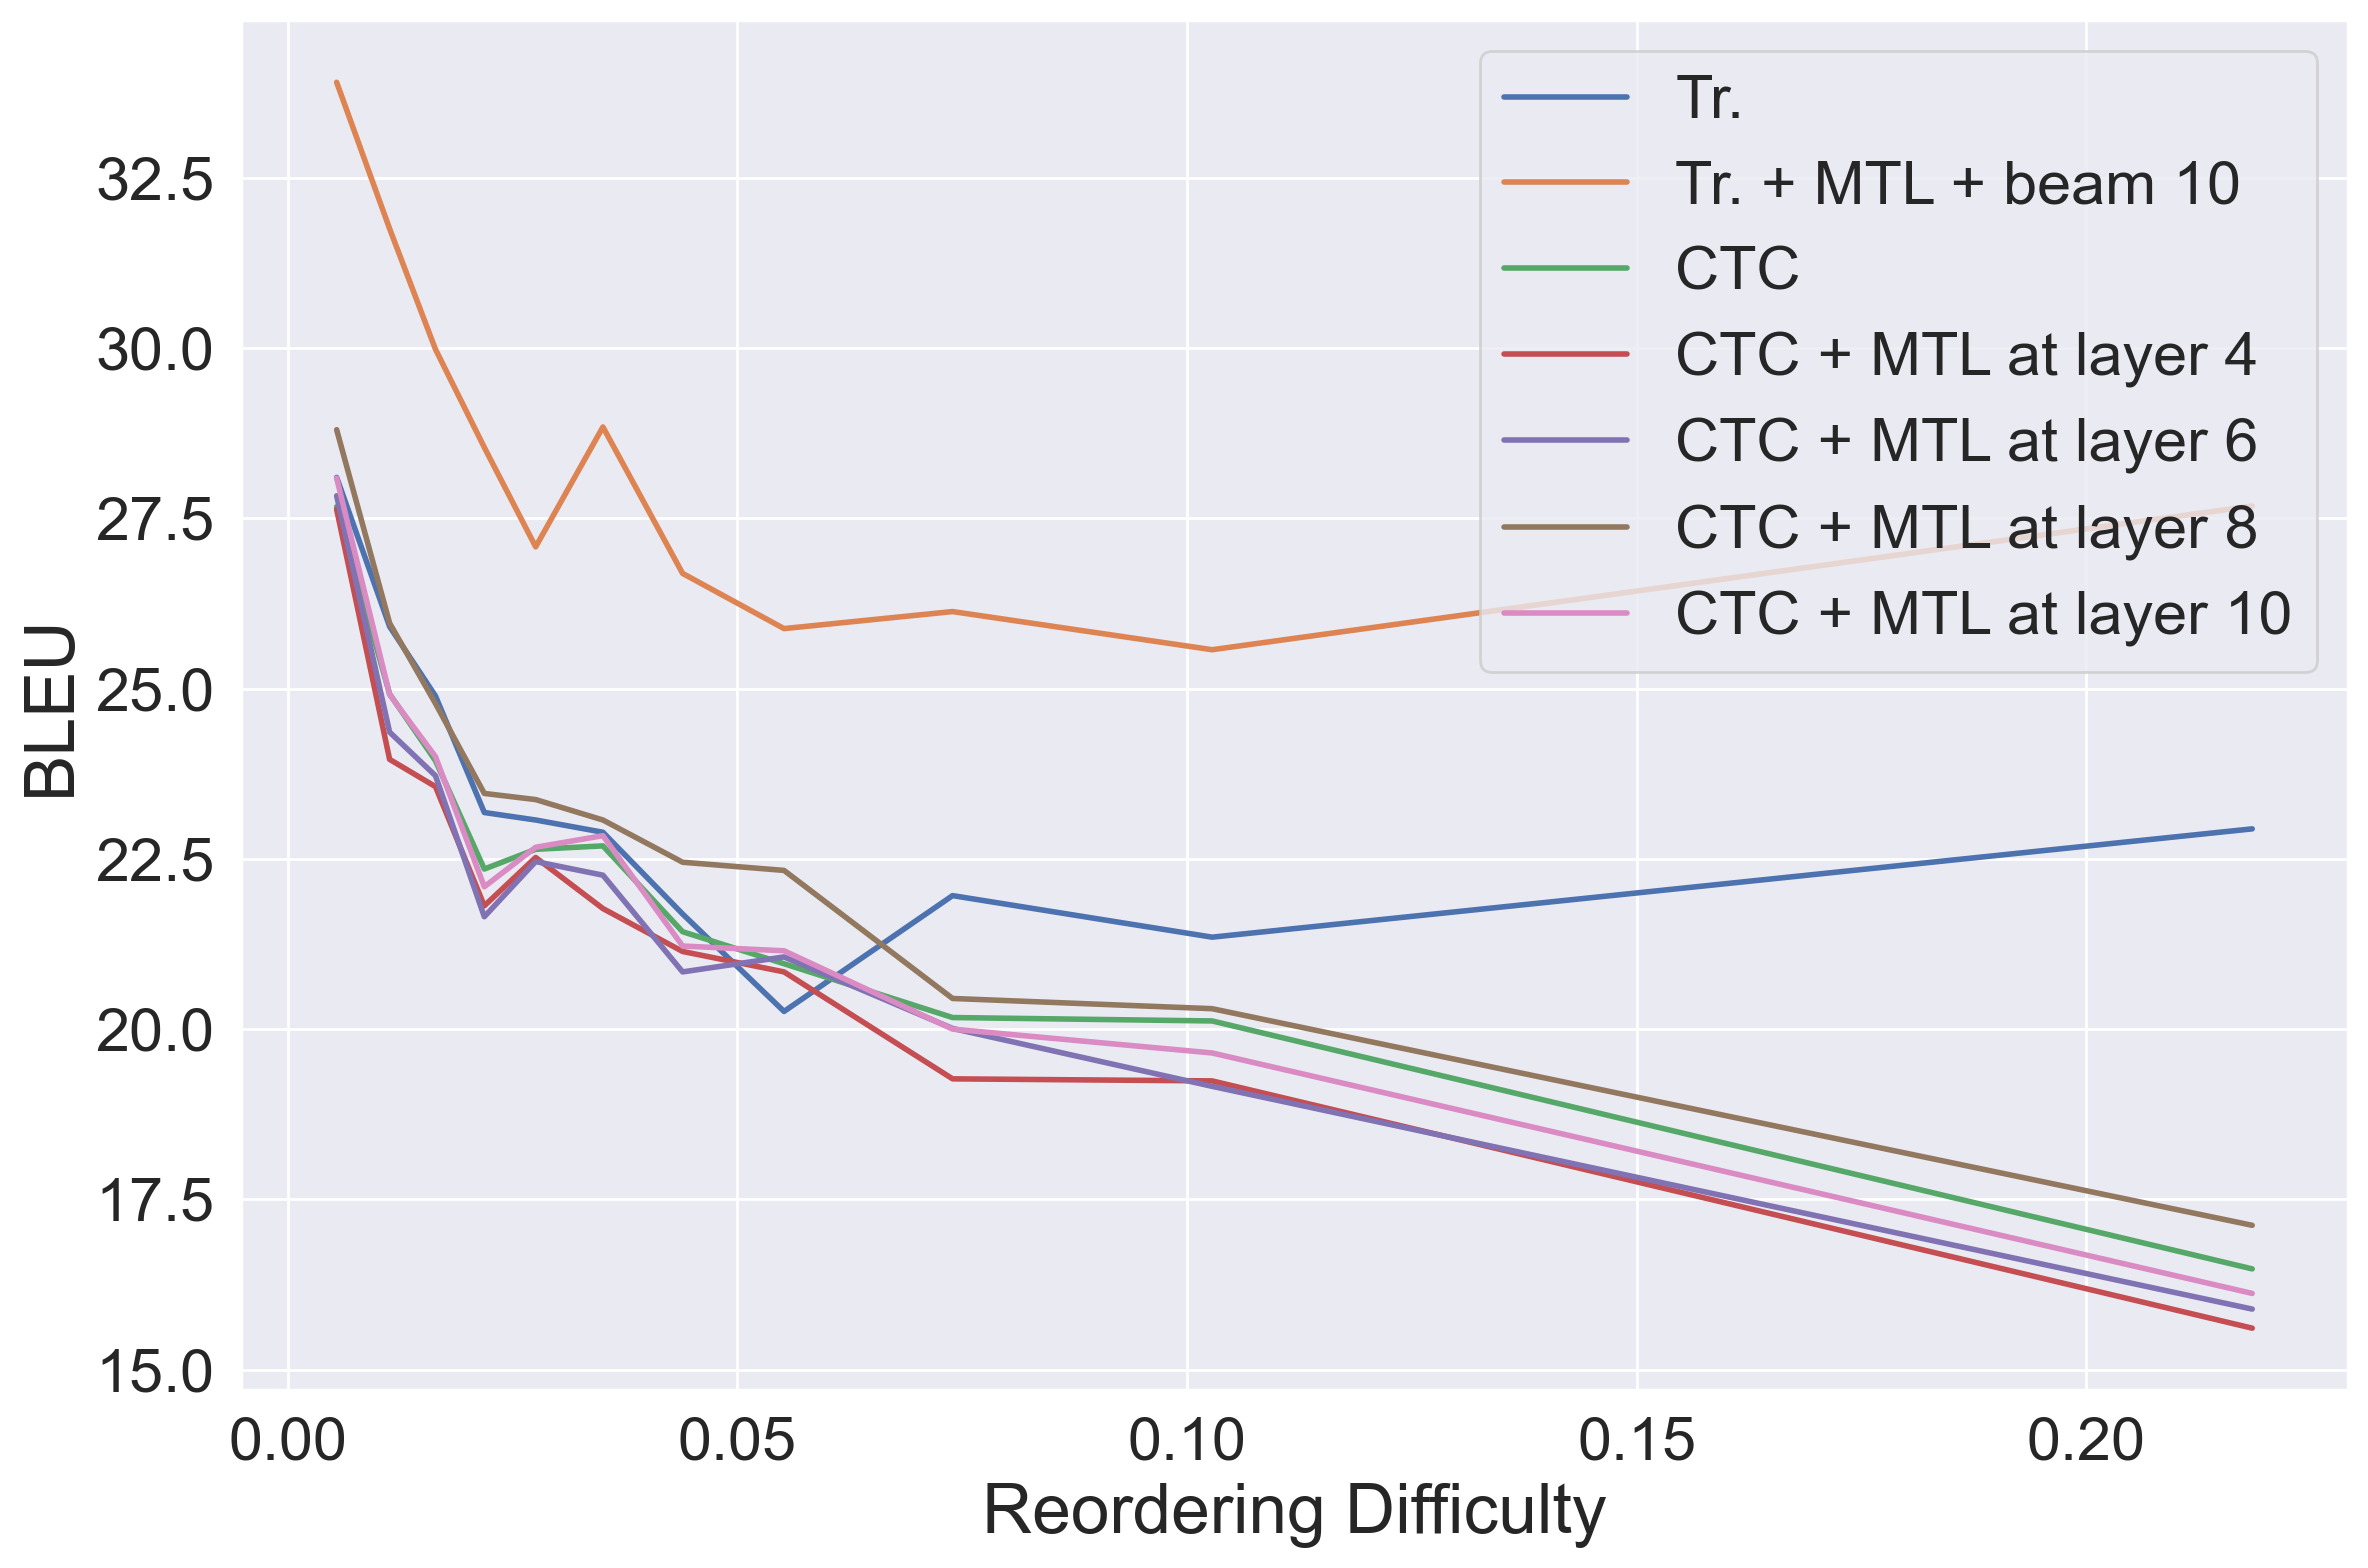

In [8]:
fig_size = (12,8)
fig = plt.figure(figsize=fig_size, dpi=200)
# titles = {m:"CTC" if m=="st" else m.replace("seg", "CTC+MTL at layer ") for m in MODEL}
titles = {
    "st": "CTC", 
    "seg4": "CTC + MTL at layer 4",
    "seg6": "CTC + MTL at layer 6",
    "seg8": "CTC + MTL at layer 8",
    "seg10": "CTC + MTL at layer 10",
    "arbeam10": "Tr. + MTL + beam 10",
    "arnomtl": "Tr."
}
markers = itertools.cycle((',')) #(('s', '+', '.', 'o', '*', 'x', 'D')) 
tick_size=22
legend_size=22
label_size=25

ax1 = fig.add_subplot(1,1,1)
for m in MODEL:
    ax1.plot(plots[m]['x'], plots[m]['y'], marker=next(markers), label=titles[m], linewidth=2) # styles[i], 

ax1.tick_params(axis='x', labelsize=tick_size)
ax1.tick_params(axis='y', labelsize=tick_size)
ax1.set_xlabel('Reordering Difficulty', fontsize=label_size)
ax1.set_ylabel('BLEU', fontsize=label_size)
ax1.legend(fontsize=legend_size, loc='upper right')
fig.tight_layout()

In [9]:
fig.savefig("bleu-ktau-curve.jpg")

In [10]:
raise

RuntimeError: No active exception to reraise

In [ ]:
"""
There is a systemic bump in BLEU score for sentences with KTD=0.18~0.22
we hypothesize that this is related to ?

(necessary?)
for AR, generally lower in the middle KTD= ? ~ ?. 
We found that ref len is generally higher in this region.
"""

In [ ]:
import sacrebleu

hyp_bleu = defaultdict(list)
for m in MODEL:
    for h, t in zip(hypos[m], refs[m]):
        bleu = sacrebleu.sentence_bleu(h, t)
        hyp_bleu[m].append(bleu.score)

In [ ]:
all_hyp_score = []
all_hyp_bleu = []
all_hyp_acc = []
for m in MODEL:
    all_hyp_score.extend(hypo_scores[m])
    all_hyp_bleu.extend(hyp_bleu[m])
    all_hyp_acc.extend(
        [max(s) for s in hypo_acc_scores[m]]
    )

In [ ]:
np.corrcoef(all_hyp_score, all_hyp_bleu)

In [ ]:
np.corrcoef(all_hyp_acc, all_hyp_bleu)

In [ ]:
np.corrcoef(all_hyp_score, all_hyp_acc)